In [1]:
import json
import pickle
import time

import matplotlib.pyplot as plt
from rdkit.Chem.rdmolfiles import MolFromSmiles

from ML4IR_components import *
from enum import Enum, auto
from rdkit import rdBase

rdBase.DisableLog('rdApp.warning')

In [2]:
class Mode(Enum):
    TRAIN = auto()  # Trains a model
    TRAIN_SAVE = auto()  # Trains and saves a model
    LOAD = auto()  # Loads the saved model

# Change this variable to swap between different behaviours
MODE = Mode.LOAD

In [3]:
if MODE is Mode.TRAIN or MODE is Mode.TRAIN_SAVE:
    def load_smiles(filename):
        nruter = dict()
        with open(filename, "r") as f_:
            for l in f_:
                fields = l.split()
                if len(fields) == 2:
                    nruter[int(fields[0])] = fields[1]
        return nruter

    smiles_data = load_smiles("data/smiles.txt")  # File containing SMILES and IDs of molecules
    targets_data = json.load(open("data/spectra.json", "r"))  # File containing IDs of molecules and the spectra
    ids = np.array(sorted(list(smiles_data.keys())))

    smiles = []
    targets = []
    bans = []
    ID_list = []
    for i in range(len(ids)):
        smi = smiles_data[ids[i]]
        if MolFromSmiles(smi) is None:
            continue
        if smi in bans:
            continue
        if smi in smiles:
            removeindex = smiles.index(smi)
            smiles.pop(removeindex)
            targets.pop(removeindex)
            ID_list.pop(removeindex)
            bans.append(smi)
            continue
        smiles.append(smi)
        targets.append(targets_data[str(ids[i])])
        ID_list.append(ids[i])
    
    print("Number of molecules: ", len(ID_list))
    
    DATA = GenerateDATA(np.array(smiles), np.array(targets)[:, :105], radius = 11)
    print("Number of fragments: ", len(DATA["IDs"]))
    start = time.time()
    model = TrainModel(DATA, [1500,1000,800,650], EMDloss)
    end = time.time()
    print(f"Training time: {(end - start):.4f}s")
    
    if MODE is Mode.TRAIN_SAVE:
        model.save("Saved_Model.keras")
        with open("DATA.pck","wb") as f:
            pickle.dump(DATA, f)

In [4]:
if MODE is Mode.LOAD:
    DATA = pickle.load(open("DATA.pck", "rb"))
    model = keras.models.load_model("Saved_Model.keras", custom_objects={ 'EMDloss': EMDloss, 'K': K })

13/13 [==============================] - 0s 7ms/step


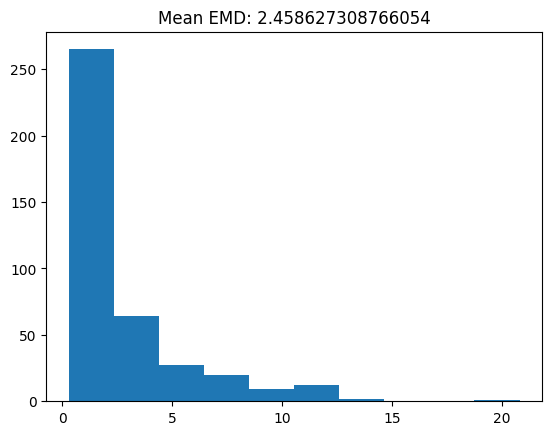

In [5]:
def PlotHist(DATA_, model_):
    plt.figure()
    preds = model_.predict(DATA_["X_test"])
    preds = preds/np.sum(preds,axis=1)[:,np.newaxis]
    Y_ = DATA_["Y_test"]
    Y_ = Y_ / np.sum(Y_, axis=1)[:, np.newaxis]
    
    EMDs = np.sum(np.abs(np.cumsum(Y_ - preds, axis = 1)), axis=1)
    
    plt.hist(EMDs)
    plt.title("Mean EMD: "+str(np.mean(EMDs)))
    
    return EMDs

_=PlotHist(DATA, model)

In [6]:
def PredictFromSMILES(smiles_, DATA_, model_):
    X = GenerateFP(smiles_, DATA_["IDs"])

    Y_pred_ = model_.predict(X.reshape(1, -1))
    Y_pred_ = Y_pred_ / np.sum(Y_pred_)
    
    return Y_pred_.flatten()

1/1 [==============================] - 0s 17ms/step


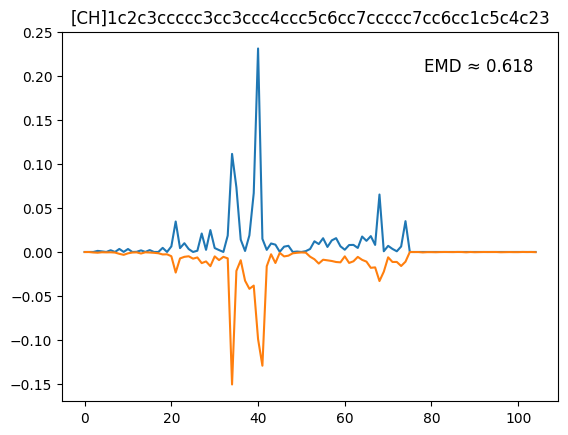

In [7]:
example_idx = 0
examplesmiles = DATA["smiles_test"][example_idx]

Y_pred = PredictFromSMILES(examplesmiles, DATA, model)

Y = DATA["Y_test"][example_idx]
Y = Y/np.sum(Y)

loss_EMD = round(np.sum(np.abs(np.cumsum(Y-Y_pred))), 3)

plt.title(examplesmiles)
plt.plot(Y)
plt.plot(-Y_pred)
plt.text(0.95, 0.93, f'EMD ≈ {loss_EMD}', horizontalalignment='right', verticalalignment='top',
         transform=plt.gca().transAxes, fontsize=12)
plt.show()